In [66]:
import FinanceDataReader as fdr

# # 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
# df = fdr.DataReader('005930')

# # Apple(AAPL), 2017-01-01 ~ Now
# df = fdr.DataReader('AAPL', '2017')

# # Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
# df = fdr.DataReader('F', '1980-01-01', '2019-12-30')

# # AMAZON(AMZN), 2017 (1년)
# df = fdr.DataReader('AMZN', '2017-01-01', '2019-12-31')

# # Samsung(005930), 2000-01-01 ~ 2019-12-31
# df = fdr.DataReader('068270', '2000-01-01', '2019-12-31')

# # country code: ex) 000150: Doosan(KR), Yihua Healthcare(CN)
# df = fdr.DataReader('000150', '2018-01-01', '2019-10-30') # KRX
df = fdr.DataReader('KS11', '2010-01-01', '2021-11-26', exchange='KRX') # KRX (위와 동일)


In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [226]:
def get_stochastic_fast_k(close_price, low, high, n=5):
    fast_k = ((close_price - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return fast_k

# Slow %K = Fast %K의 m기간 이동평균(SMA)
def get_stochastic_slow_k(fast_k, n=3):
    slow_k = fast_k.rolling(n).mean()
    return slow_k

# Slow %D = Slow %K의 t기간 이동평균(SMA)
def get_stochastic_slow_d(slow_k, n=3):
    slow_d = slow_k.rolling(n).mean()
    return slow_d

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

def get_rsi(price, period=14):
    delta = price.diff()
    gains, declines = delta.copy(), delta.copy()
    gains[gains < 0] = 0
    declines[declines > 0] = 0
    
    _gain = gains.ewm(com=(period-1), min_periods=period).mean()
    _loss = declines.abs().ewm(com=(period-1), min_periods=period).mean()
    RS = _gain / _loss
    
    return pd.Series(100 - (100/(1+RS)), name = 'RSI')

## MA: 이동평균선
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA60'] = df['Close'].rolling(window=60).mean()
# df['MA200'] = df['Close'].rolling(window=200).mean()

df['stddev'] = df['Close'].rolling(window=20).std() # 20일 이동표준편차
df['upper'] = df['MA20'] + 2*df['stddev'] # 상단밴드
df['lower'] = df['MA20'] - 2*df['stddev'] # 하단밴드
df['upper-lower'] = df['upper']-df['lower']

df['MA20-MA5'] = df['MA20'] - df['MA5']
df['MA60-MA20'] = df['MA60'] - df['MA20']


# MACD
macd_short, macd_long, macd_signal=12,26,9 #기본값
df["MACD_short"]=df['Close'].ewm(span=macd_short).mean()
df["MACD_long"]=df['Close'].ewm(span=macd_long).mean()
df["MACD"]=df.apply(lambda x: (x["MACD_short"]-x["MACD_long"]), axis=1)
df["MACD_signal"]=df["MACD"].ewm(span=macd_signal).mean()  
df["MACD_oscillator"]=df.apply(lambda x:(x["MACD"]-x["MACD_signal"]), axis=1)
df["MACD_sign"]=df.apply(lambda x: ("매수" if x["MACD"]>x["MACD_signal"] else "매도"), axis=1)


# fast_k, slow_k, slow_d를 획득
df['fast_k5'] = get_stochastic_fast_k(df['Close'], df['Low'], df['High'], 5)
df['slow_k3'] = get_stochastic_slow_k(df['fast_k5'], 3)
df['slow_d3'] = get_stochastic_slow_d(df['slow_k3'], 3)

df['fast_k10'] = get_stochastic_fast_k(df['Close'], df['Low'], df['High'], 10)
df['slow_k6'] = get_stochastic_slow_k(df['fast_k10'], 6)
df['slow_d6'] = get_stochastic_slow_d(df['slow_k6'], 6)

df['fast_k20'] = get_stochastic_fast_k(df['Close'], df['Low'], df['High'], 20)
df['slow_k12'] = get_stochastic_slow_k(df['fast_k20'], 12)
df['slow_d12'] = get_stochastic_slow_d(df['slow_k12'], 12)


# RSI
df['rsi'] = get_rsi(df['Close'])

In [325]:
df['MA20-MA5'].mean()
df['MA60-MA20'].mean()

-9.578509780092594

In [70]:
df

,Close,Open,High,Low,Volume,Change,MA5,MA20,MA60,MACD_short,...,fast_k5,slow_k3,slow_d3,fast_k10,slow_k6,slow_d6,fast_k20,slow_k12,slow_d12,rsi
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1696.14,1681.71,1696.14,1681.71,296550000.0,0.0079,NaN,NaN,NaN,1696.140000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1690.62,1701.62,1702.39,1686.45,408850000.0,-0.0033,NaN,NaN,NaN,1693.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,1705.32,1697.88,1706.89,1696.10,426040000.0,0.0087,NaN,NaN,NaN,1697.899954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,1683.45,1702.92,1707.90,1683.45,462400000.0,-0.0128,NaN,NaN,NaN,1693.338668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,1695.26,1694.06,1695.26,1668.84,379950000.0,0.0070,1694.158,NaN,NaN,1693.860687,...,67.639529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-22,3013.25,2983.38,3018.01,2980.73,530960000.0,0.0142,2978.256,2980.6390,3049.147667,2977.110115,...,94.085487,50.792450,46.544114,95.835156,67.644003,50.148578,74.041777,41.755887,45.077062,53.716124
2021-11-23,2997.33,3013.16,3016.36,2992.14,524230000.0,-0.0053,2978.280,2978.0515,3046.798167,2980.220867,...,74.304175,71.144458,53.152671,81.905679,69.067452,56.223654,64.425327,43.363730,44.391978,50.991050
2021-11-24,2994.29,3006.34,3017.90,2981.02,556640000.0,-0.0010,2984.654,2976.4915,3044.256167,2982.385349,...,70.526839,79.638834,67.191914,79.245778,68.974470,60.740493,69.296098,45.880889,43.944713,50.464577


In [227]:
df['Close_t+5'] = df['Close'].shift(-5)
df['Close_t+10'] = df['Close'].shift(-10)
df['Close_t+20'] = df['Close'].shift(-20)

features = [
    'Close', 'Open', 'High', 'Low', 'Volume', 'MA5', 'MA20', 'MA60', 
    'MA60-MA20', 'MA20-MA5', 'MACD', 'MACD_oscillator', 
    'MACD_signal', 'fast_k5', 'slow_k3', 'slow_d3', 'fast_k10', 'slow_k6', 'slow_d6', 
    'fast_k20', 'slow_k12', 'slow_d12', 'rsi', 'upper', 'lower', 'stddev', 'upper-lower'
]

for feature in features:
    df[feature+'-1']=df[feature].shift(1)

### 1. Regression으로 진행 (안됨)

In [128]:
df['earn+5'] = df['Close_t+5']-df['Close'] #(df['Close'] < df['Close_t+5']).astype(int)
df['earn+10'] = df['Close_t+10']-df['Close'] #(df['Close'] < df['Close_t+10']).astype(int)
df['earn+20'] = df['Close_t+20']-df['Close'] #(df['Close'] < df['Close_t+20']).astype(int)

Text(0.5, 1.0, 'earn+20 size')

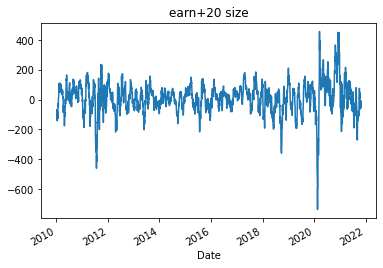

In [129]:
df['earn+20'].plot()
plt.title('earn+20 size')

In [85]:
df_na = df.dropna()
target = df_na['earn+20']

In [94]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_na[features], target, test_size=0.25, random_state=123456)


In [98]:
from sklearn.linear_model import LinearRegression


lm = LinearRegression(fit_intercept=True, normalize=True, n_jobs=None)
lm.fit(X_train, y_train)
accuracy = lm.score(X_test, y_test)
print("Linear Regression test file accuracy:"+str(accuracy))


Linear Regression test file accuracy:0.057716697677128614


/Users/hyunsuk/.pyenv/versions/3.9.1/envs/ds/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


In [99]:
lm.coef_

array([-6.13120641e-01, -2.98599739e-01,  8.49312554e-01, -4.40871441e-01,
        7.18278559e-08, -9.61937281e-01,  6.12754075e-01,  7.77471656e-01,
        1.96909762e+00,  2.57807818e+00,  1.97042220e+00, -4.41000779e-03,
       -6.60157371e-01,  6.91362182e-01,  1.10094061e-02, -7.33418830e-01,
       -7.24416092e-02,  3.82928770e-02, -4.84667020e-01, -1.05420667e+00,
        2.92874415e+00])

### 2. Random Forest 분류로 진행

Text(0.5, 1.0, 'earn+20 size')

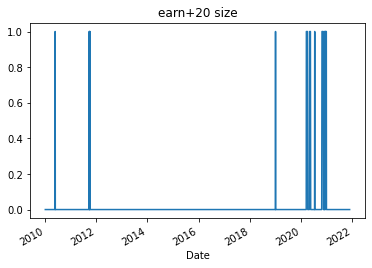

In [228]:
df['earn+5'] = (1.1*df['Close'] < df['Close_t+5']).astype(int)
df['earn+10'] = (1.05*df['Close'] < df['Close_t+10']).astype(int)
df['earn+20'] = (1.1*df['Close'] < df['Close_t+20']).astype(int)

df['earn+20'].plot()
plt.title('earn+20 size')

In [229]:
df_na = df.dropna()
len(df_na[df['earn+20']==1])

<ipython-input-229-df9304a44f2b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df_na[df['earn+20']==1])


64

In [278]:
features = [
    'Volume-1', 'MA20-MA5-1', 'MA60-MA20-1', 'MACD-1', 'MACD_oscillator-1', 
    'MACD_signal-1', 'slow_k3-1', 'slow_d3-1', 'slow_k6-1', 'slow_d6-1', 
    'slow_k12-1', 'slow_d12-1', 'rsi-1', 'upper-1', 'lower-1', 'stddev-1', 'upper-lower-1'
]

target = df_na['earn+20']

In [279]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_na[features], target, test_size=0.25, random_state=3456)


In [280]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

/Users/hyunsuk/.pyenv/versions/3.9.1/envs/ds/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForestClassifier(oob_score=True, random_state=123456)

In [281]:
from sklearn.metrics import accuracy_score

predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')


Out-of-bag score estimate: 0.986
Mean accuracy score: 0.987


### >> 예측 실패시 손실

In [328]:
df_loss = df.loc[y_test[(y_test!=predicted) & (predicted==1)].index]
print('avg: {}'.format((df_loss['Close_t+20'] - df_loss['Close']).mean()))
print('min: {}'.format((df_loss['Close_t+20'] - df_loss['Close']).min()))
print('max: {}'.format((df_loss['Close_t+20'] - df_loss['Close']).max()))


avg: 37.830000000000155
min: 37.830000000000155
max: 37.830000000000155


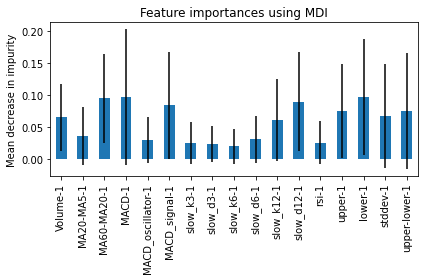

In [297]:
import numpy as np

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

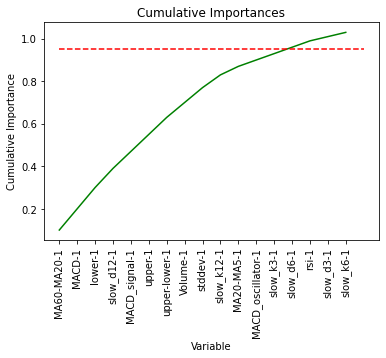

In [302]:
# Get numerical feature importances

importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

x_values = list(range(len(importances)))

sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

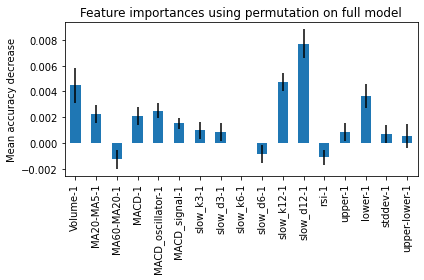

In [303]:
# Permutation Importance
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


### 3. Logistic Regression

Text(0.5, 1.0, 'earn+20 size')

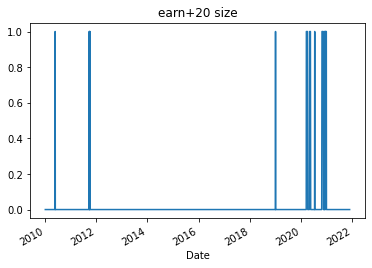

In [164]:
df['earn+5'] = (1.1*df['Close'] < df['Close_t+5']).astype(int)
df['earn+10'] = (1.05*df['Close'] < df['Close_t+10']).astype(int)
df['earn+20'] = (1.1*df['Close'] < df['Close_t+20']).astype(int)

df['earn+20'].plot()
plt.title('earn+20 size')

In [165]:
df_na = df.dropna()

In [213]:
len(df_na)   #2860
len(df_na[df_na['earn+20']==1])  #64

64

In [272]:
features = [
    'Volume-1', 'MA20-MA5-1', 'MA60-MA20-1', 'MACD-1', 'MACD_oscillator-1', 
    'MACD_signal-1', 'slow_k3-1', 'slow_d3-1', 'slow_k6-1', 'slow_d6-1', 
    'slow_k12-1', 'slow_d12-1', 'rsi-1', 'upper-1', 'lower-1', 'stddev-1', 'upper-lower-1'
]

target = df_na['earn+20']

In [273]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_na[features], target, test_size=0.25, random_state=3456)

In [274]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [275]:
model.score(X_train, y_train)
model.coef_

array([[ 0.7433049 ,  1.17893269,  1.80138369,  1.11362609, -0.06365772,
         1.20631182, -0.2066521 ,  0.43618561,  0.48660171, -1.11305984,
         0.30225714,  0.15845494,  0.23341359, -0.14904132, -0.24369882,
         0.31564063,  0.31564063]])

In [276]:
pd.DataFrame(model.coef_[0], features, columns=['coef']).sort_values(by='coef', ascending=False)

,coef
MA60-MA20-1,1.801384
MACD_signal-1,1.206312
MA20-MA5-1,1.178933
MACD-1,1.113626
Volume-1,0.743305
slow_k6-1,0.486602
slow_d3-1,0.436186
stddev-1,0.315641
upper-lower-1,0.315641
slow_k12-1,0.302257
